In [1]:
#| echo: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from utils import logreg_accuracy

In [2]:
#| echo: false
df = pd.read_csv("./data/balanced_cinnamon_quality_dataset.csv")

### Exploratory data analysis

This dataset contains analytical results for 60 cinnamon samples. Each sample is defined by a unique `Sample_ID` and characterized by six explanatory features: `Moisture`, `Ash`, `Volatile_Oil`, `Acid_Insoluble_Ash`, `Chromium`, and `Coumarin`. The goal of the analysis is to predict or explain the `Quality_Label`, which is the target feature. The dataset is complete and free of duplicates.

In [3]:
#| echo: false
#| output: false
print(f'Number of samples {df.shape[0]}')
print(f'Number of features {df.shape[1]}')

Number of samples 60
Number of features 8


In [4]:
#| echo: false
#| output: false
df.head()

,Sample_ID,Moisture (%),Ash (%),Volatile_Oil (%),Acid_Insoluble_Ash (%),Chromium (mg/kg),Coumarin (mg/kg),Quality_Label
0,H001,10.56,5.93,1.24,0.28,0.0019,0.0021,High
1,H002,11.43,5.60,1.35,0.25,0.0016,0.0039,High
2,H003,11.10,5.70,1.21,0.37,0.0013,0.0029,High
3,H004,10.90,5.76,1.47,0.27,0.0011,0.0035,High
4,H005,10.23,5.82,1.28,0.26,0.0013,0.0047,High


In [5]:
#| echo: false
#| output: false
# Duplicated samples
any(df['Sample_ID'].value_counts() > 1)

False

In [6]:
#| echo: false
#| output: false
# NA values by features
df.isna().sum()

Sample_ID                 0
Moisture (%)              0
Ash (%)                   0
Volatile_Oil (%)          0
Acid_Insoluble_Ash (%)    0
Chromium (mg/kg)          0
Coumarin (mg/kg)          0
Quality_Label             0
dtype: int64

The `Quality_Label` feature has three levels: `Low`, `Medium` and `High`. The dataset is perfectly balanced, with each class containing exactly 20 samples.

In [7]:
#| echo: false
#| output: false
# Target feature distribution
df['Quality_Label'].value_counts()

Quality_Label
High      20
Medium    20
Low       20
Name: count, dtype: int64

Sample distribution analysis for the explanatory features is done, see @fig-density-exp. 

In [8]:
#| echo: false
#| output: false
features = df.drop(['Quality_Label', 'Sample_ID'],axis = 1).columns.tolist()

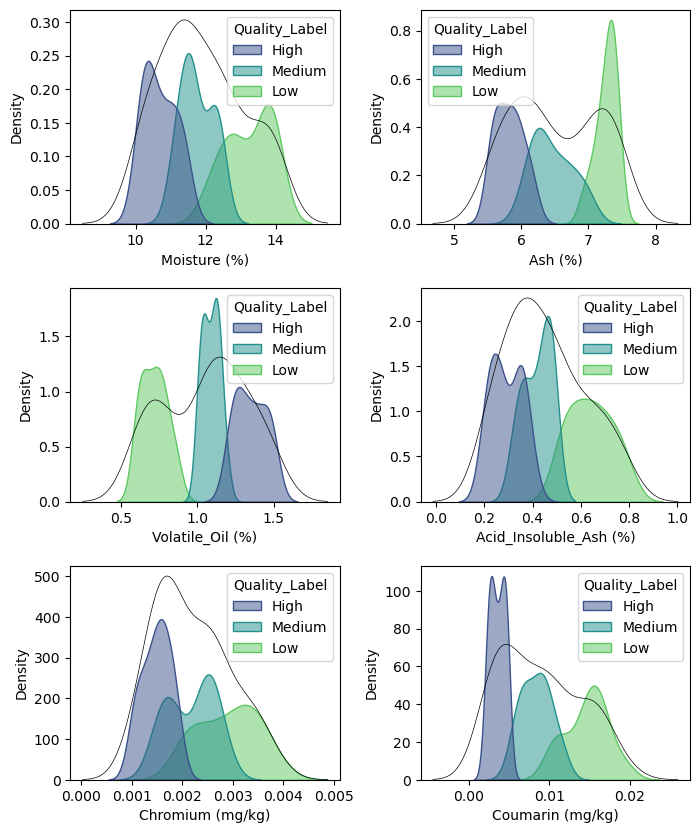

In [9]:
#| label: fig-density-exp
#| fig-cap: "Density plots for each explanatory feature, showing the distribution of all samples (black line) overlaid with distributions colored by Quality_Label (Low, Medium, High)."
plt.figure(figsize=(8, 10))  # Dynamic figure size
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
for i, feature in enumerate(features,start=1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df, x=feature, fill=True, hue='Quality_Label', alpha=0.5, palette='viridis')
    sns.kdeplot(data=df, x=feature, linewidth=0.5, color='black')
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.show()


The correlations between most features are strong (above 0.80) as shown in @fig-density-exp. `Chromium` is the exception, showing the lowest correlations, suggesting it may contain different information about the target.

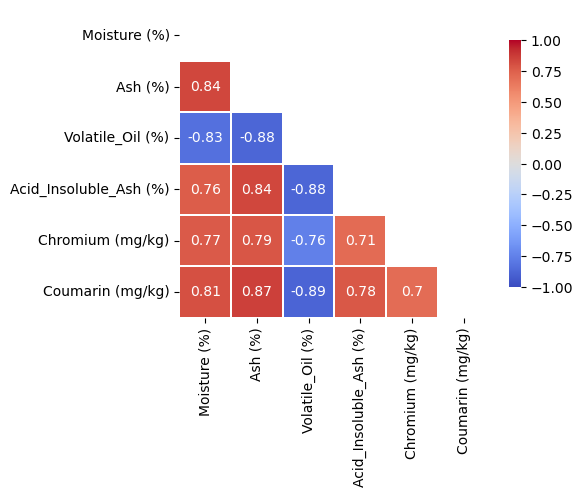

In [10]:
#| label: fig-corr-exp
#| fig-cap: "Pearson correlations coeficients between the explanatory features."
# Correlation between features
corr = df[features].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(5, 4))

sns.heatmap(corr, mask=mask,
            vmin = -1.0, vmax=1.0, center=0.0,
            linewidths=.1, cmap="coolwarm", 
            cbar_kws={"shrink": .8},
            annot = True)

plt.show()

The relationship between explanatory features and target is also analyzed using violin plots (@fig-corr-target) and ANOVA tests (@fig-f-test). Through the F-test values, we can assess the potencial of variables for classification.

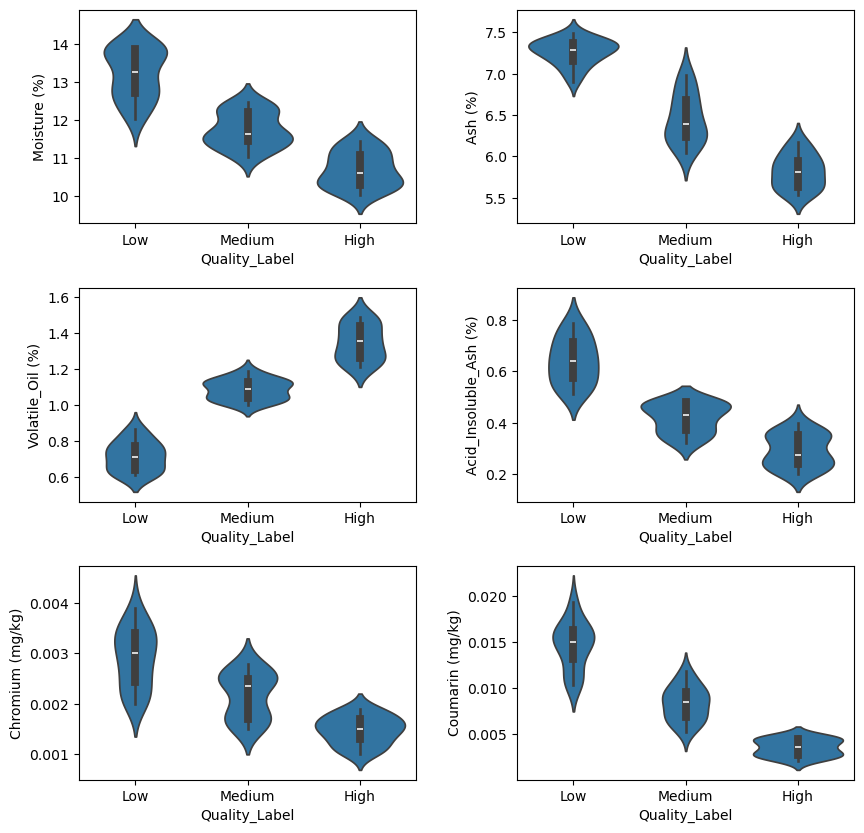

In [11]:
#| label: fig-corr-target
#| fig-cap: "Violin plots showing distribution of each explanatory feature, stratified by Quality_Label categories"
# Violin plot each feature (+ boxplot)
plt.figure(figsize=(10, 10))  # Dynamic figure size
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
for i, feature in enumerate(features,start=1):
    plt.subplot(3, 2, i)
    sns.violinplot(x = "Quality_Label", y = feature, data = df, 
                   inner = "box", order=['Low', 'Medium', 'High'])
plt.show()

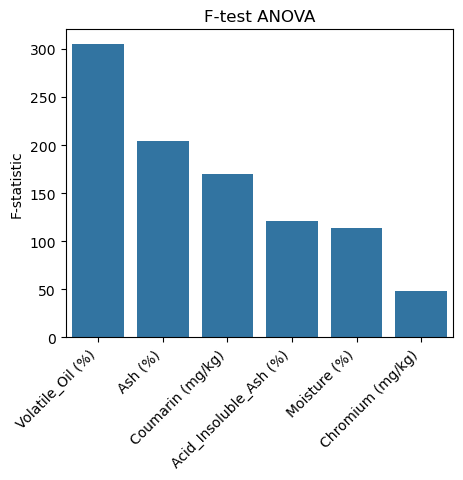

In [12]:
#| label: fig-f-test
#| fig-cap: "F-statistics from ANOVA tests assessing the relationship between each explanatory feature and the target variable."
# ANOVA test
plt.figure(figsize=(5, 4))  # Dynamic figure size
f_scores, p_values = f_classif(df[features], df["Quality_Label"])
df_anova = pd.DataFrame({'feature': features, 'f_score': f_scores}).sort_values('f_score',ascending=False)
features_anova = list(df_anova['feature'])
sns.barplot(x='feature', y='f_score', data=df_anova)
plt.xlabel('')
plt.xticks(rotation=45, ha = 'right')
plt.ylabel('F-statistic')
plt.title('F-test ANOVA')
plt.show()

As shown by its dominant F-statistic in @fig-f-test, the `Volatile Oil` feature possesses the highest classification potential. This is strongly supported by the clear separation of its density distributions across quality levels in @fig-density-exp and its behavior in @fig-corr-target. The features `Ash` and `Coumarin` also demonstrate significant predictive power, ranking as the next most important features. In contrast, `Chromium` is the least effective classifier, a conclusion drawn from its low F-statistic and the extensive overlap of its distributions across all quality labels.

### Feature selection

At this stage, given that we have several variables with high predictive power, building a 100% accurate model using all of them would be straightforward. The real challenge lies in determining how far we can push feature selection to develop the simplest possible model using the fewest variables. This approach would be particularly attractive for companies looking to reduce costs in their analytical processes—fewer variables for classification would automatically mean fewer required analyses, leading to immediate cost reductions. We define our objective here as finding the simplest possible model capable of classifying samples with 100% accuracy.

#### Volatile Oil feature as discriminant

As can be seen in the following plot, based on the available data, `Volatile Oil` could serve as a discriminant feature for sample classification. This parameter enables the definition of two discriminatory thresholds for flawless sample classification. The low-quality threshold would correspond to the average of maximum value observed in the low-quality group and the minimum value from the intermediate-quality group. Samples falling below this cutoff would be categorically classified as low quality. Analogously, a second threshold could be derived to differentiate high-quality and intermediate-quality specimens.

In [13]:
#| output: true
# build thresholds for classification
df_agg = df.groupby('Quality_Label')['Volatile_Oil (%)'].agg(['mean','min','max'])
low_medium = (df_agg['max']['Low'] + df_agg['min']['Medium'])/2
medium_high = (df_agg['max']['Medium'] + df_agg['min']['High'])/2
print('Discriminant feature: Volatile_Oil (%)')
print(f'\tLow Quality: Volatile Oil (%) < {low_medium}')
print(f'\tMedium Quality: {low_medium} < Volatile Oil (%) < {medium_high}')
print(f'\tHigh Quality: Volatile Oil (%) < {medium_high}')

Discriminant feature: Volatile_Oil (%)
	Low Quality: Volatile Oil (%) < 0.935
	Medium Quality: 0.935 < Volatile Oil (%) < 1.2
	High Quality: Volatile Oil (%) < 1.2


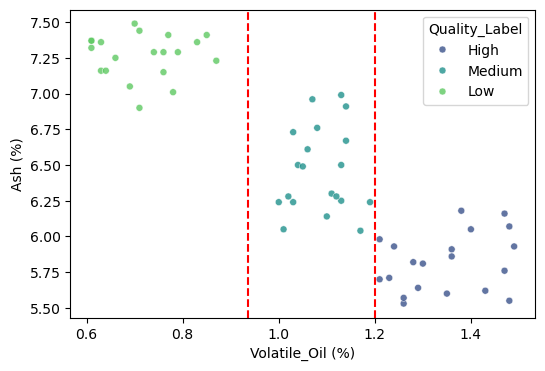

In [14]:
#| label: fig-volatile-oil
#| fig-cap: "Plot for Volatile Oil and Ash features. Thresholds for classification are shown (red lines)"
# plot volatile_oil versus ash
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Volatile_Oil (%)', y='Ash (%)', hue='Quality_Label', 
                data=df, palette='viridis', 
                s=25, alpha=0.8)
plt.axvline(x=low_medium, color='r', linestyle='--', label='Vertical Line')
plt.axvline(x=medium_high, color='r', linestyle='--', label='Vertical Line')
plt.show()

The model demonstrates high reliability in identifying low-quality samples, which are clearly distinct from the others (@fig-volatile-oil). However, the differentiation between medium and high-quality samples is less distinct, suggesting lower classification confidence for these groups.


To test the robustness of this model, a bootstraping strategy is applied and 1000 train/test datasets will be generated. The model's predictive performance will be evaluated on these different datasets using accuracy, precision and recall.

In [15]:
#| echo: false
#| output: false
# bootstraping (1000 dataset train/validation)
random.seed(42)
train_test = []
for _ in range(1000):
    train = random.choices(range(60), k=60)
    test = [num for num in range(60) if num not in train]
    train_test.append((train,test))

In [16]:
# Classification using Volatile Oil (%) discrimination
acc_volatile = []
precision = []
recall = []
for train, test in train_test:
    # build data train
    df_train = df.iloc[train]
    # build data test
    df_test = df.iloc[test]
    # calculate low_medium train and medium_high train
    df_agg = df_train.groupby('Quality_Label')['Volatile_Oil (%)'].agg(['min','max'])
    low_medium = (df_agg['max']['Low'] + df_agg['min']['Medium'])/2
    medium_high = (df_agg['max']['Medium'] + df_agg['min']['High'])/2
    # predict test
    y_pred = list(map(lambda x: "High" if x > medium_high else ("Medium" if x > low_medium else "Low"), df_test['Volatile_Oil (%)']))
    y = df_test['Quality_Label']
    # accuracy
    precision.append(precision_score(y, y_pred, average=None, labels = ['Low', 'Medium', 'High']))
    recall.append(recall_score(y, y_pred, average=None, labels = ['Low', 'Medium', 'High']))
    acc_volatile.append(accuracy_score(y, y_pred))

df_precision = pd.DataFrame(np.array(precision))
df_precision.columns = ['Precision Low', 'Precision Medium', 'Precision High']
df_recall = pd.DataFrame(np.array(recall))
df_recall.columns = ['Recall Low', 'Recall Medium', 'Recall High']
df_stats = pd.concat([df_precision, df_recall], axis = 1)
df_stats['Accuracy'] = acc_volatile

df_stats.mean(axis = 0)

Precision Low       1.000000
Precision Medium    0.977086
Precision High      0.986053
Recall Low          1.000000
Recall Medium       0.987066
Recall High         0.976602
Accuracy            0.986723
dtype: float64

The model demonstrates excellent performance across all three classification levels (Low, Medium, High). Precision and recall for Low are perfect (1.0), while Medium and High show near-perfect scores. Overall accuracy is 98.7%, indicating highly reliable predictions with minimal errors. The balanced results suggest strong generalization across all classes.

#### Logistic regression for selected features 

As previously noted, the available data makes it straightforward to achieve a model with 100% accuracy. The real challenge now is to develop the simplest possible model using the minimal set of features. Given these premises—and considering the previous model’s inability to achieve perfect classification—we will test multiple logistic regression models with different feature combinations.

Feature selection will be guided by the predictive power analyzed above. Three models will be evaluated considering different combinations of features. The simplest model uses the two most predictive features (`Volatile Oil` and `Ash`). Less predective features (`Coumarin` and `Acid Insoluble Ash`) will be added to the model if necessary to improve the results. `Chromium` feature is also added in some models. While this feature has limited predictive power, its low correlation with other features makes it worth evaluating for potential added information.

The robustness of these models was also verified using the 100 train-test splits generated previously.

In [17]:
# log regression for bootstraping (1000 train-test splits)
experiments = {
               'Log. Regr. VO + Ash': ['Volatile_Oil (%)', 'Ash (%)'],
               'Log. Regr. VO + Ash + Chromium': ['Volatile_Oil (%)', 'Ash (%)', 'Chromium (mg/kg)'],
               'Log. Regr. VO + Ash + Coumarin': ['Volatile_Oil (%)', 'Ash (%)', 'Coumarin (mg/kg)'],
               'Log. Regr. VO + Ash + Coumarin + Chromium': ['Volatile_Oil (%)', 'Ash (%)', 'Coumarin (mg/kg)', 'Chromium (mg/kg)'],
               'Log. Regr. VO + Ash + Coumarin + Acid Insoluble Ash': ['Volatile_Oil (%)', 'Ash (%)', 'Coumarin (mg/kg)','Acid_Insoluble_Ash (%)']
              }

lst_prop = []
print('Model'.ljust(60), 'Accuracy')
print('-'*60,'--------')
for name_experiment, features_sel in experiments.items():
    accuracy = logreg_accuracy(df, train_test, features_sel, 'Quality_Label')
    print(f'{name_experiment.ljust(60)} {np.mean(accuracy):.3f}')
print('VO: Volatile Oil')


Model                                                        Accuracy
------------------------------------------------------------ --------
Log. Regr. VO + Ash                                          0.987
Log. Regr. VO + Ash + Chromium                               0.978
Log. Regr. VO + Ash + Coumarin                               0.996
Log. Regr. VO + Ash + Coumarin + Chromium                    0.985
Log. Regr. VO + Ash + Coumarin + Acid Insoluble Ash          0.999
VO: Volatile Oil


### Conclusions

The simplest model, based solely on `Volatile Oil`, effectively distinguishes Low-quality samples from the Medium and High categories but lacks the robustness for full three-class discrimination. Achieving perfect accuracy (1.0) requires a model incorporating the four most predictive features: `Volatile Oil`, `Ash`, `Coumarin`, and `Acid Insoluble Ash`. Despite its low correlation with other variables, `Chromium` provides no additional predictive value and its inclusion reduces model robustness.

**A logistic regression classifier trained on the subset of features comprising `Volatile Oil`, `Ash`, `Coumarin`, and `Acid Insoluble Ash` yielded perfect predictive accuracy.**